<a href="https://colab.research.google.com/github/vvvu/pytorch-toys/blob/main/Autoencoder_on_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
image_size = 784
num_epochs = 50
learning_rate = 1e-3
batch_size = 128 # 每个batch有多少个样本

# MNIST dataset
dataset = torchvision.datasets.MNIST(root = './data',
                                     train = True,
                                     transform = transforms.ToTensor(),
                                     download = True)

# Data Loader
data_loader = torch.utils.data.DataLoader(dataset = dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# AE Model
class AE(nn.Module):
  def __init__(self, image_size = 784):
    super(AE, self).__init__()
    '''
    encoder
    '''
    self.enc_fc1 = nn.Linear(in_features = image_size, out_features = 256)
    self.enc_fc2 = nn.Linear(in_features = 256, out_features = 128)
    self.enc_fc3 = nn.Linear(in_features = 128, out_features = 64)
    self.enc_fc4 = nn.Linear(in_features = 64, out_features = 32)
    self.enc_fc5 = nn.Linear(in_features = 32, out_features = 16)

    '''
    decoder
    '''
    self.dec_fc1 = nn.Linear(in_features = 16, out_features = 32)
    self.dec_fc2 = nn.Linear(in_features = 32, out_features = 64)
    self.dec_fc3 = nn.Linear(in_features = 64, out_features = 128)
    self.dec_fc4 = nn.Linear(in_features = 128, out_features = 256)
    self.dec_fc5 = nn.Linear(in_features = 256, out_features = image_size)

  def forward(self, x):
    x = F.relu(self.enc_fc1(x))
    x = F.relu(self.enc_fc2(x))
    x = F.relu(self.enc_fc3(x))
    x = F.relu(self.enc_fc4(x))
    x = F.relu(self.enc_fc5(x))

    x = F.relu(self.dec_fc1(x))
    x = F.relu(self.dec_fc2(x))
    x = F.relu(self.dec_fc3(x))
    x = F.relu(self.dec_fc4(x))
    x = F.relu(self.dec_fc5(x))
    return x

In [4]:
model = AE().to(device)
print(model)

AE(
  (enc_fc1): Linear(in_features=784, out_features=256, bias=True)
  (enc_fc2): Linear(in_features=256, out_features=128, bias=True)
  (enc_fc3): Linear(in_features=128, out_features=64, bias=True)
  (enc_fc4): Linear(in_features=64, out_features=32, bias=True)
  (enc_fc5): Linear(in_features=32, out_features=16, bias=True)
  (dec_fc1): Linear(in_features=16, out_features=32, bias=True)
  (dec_fc2): Linear(in_features=32, out_features=64, bias=True)
  (dec_fc3): Linear(in_features=64, out_features=128, bias=True)
  (dec_fc4): Linear(in_features=128, out_features=256, bias=True)
  (dec_fc5): Linear(in_features=256, out_features=784, bias=True)
)


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

### running_loss与loss
- 第一种情况：将epoch内部再次划分为多个batch，所以`loss.item()`实际上是每一个batch的loss，我们需要用`running_loss`将其求和，然后就可以求出一个epoch中的平均`loss`
```python
for epoch in range(num_epochs):
  running_loss = 0
  for data in data_loader:
    ....
    ....
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    ....
```

- 第二种情况：这种情况下数据集没有划分为batch，所以一个epoch的`loss`直接通过`loss.item()`得到即可
```python
for epoch in range(num_epochs):
  ....
  ....
  loss.backward()
  optimizer.step()
  print(loss.item())
```

In [6]:
# Start training
train_loss = []
for epoch in range(num_epochs):
  running_loss = 0.0
  '''
  len(data_loader):
  1. MNIST总共有6w张图片
  2. batch_size = 128，说明每一个batch我们有128个样本
  3. len(data_loader) = 60000/128 = 469
  '''
  for batch_id, (img, label) in enumerate(data_loader):
    '''
    1. batch_id: 当前读入的MNIST数据集的第几批，总共有60000/128 = 469批
    2. img: 其中每一个batch有batch_size=128张图片
    3. label: Tensor，维度1x128，存储每张图片对应的Label
    '''
    # Forward pass
    img = img.to(device).view(-1, image_size)
    '''
    .view(-1, b)，-1代表不确定，这里代表你不确定将28x28的图片压缩成几行，但你可以肯定要压缩成image_size = 784列
    效果上等同于28 x 28 => 1 x 784
    '''

    # Backprop and optimize
    optimizer.zero_grad()
    outputs_image = model(img) # Reconstruction Image
    loss = criterion(outputs_image, img) # Reconstruction Error
    '''
    1. 这里的loss是当前epoch的loss
    '''
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    '''
    - The 'item()' method extracts the loss's value as a Python float
    因为我们实际上是希望得到loss的标量值，而这里的loss实际上是计算图的一部分，
    是一个Tensor而并非是一个scalar，所以我们要使用loss.item()进行转换
    '''

  loss = running_loss / len(data_loader)
  '''
  running_loss记录的是每一个epoch中的loss平均值
  1. 当前我们这批数据有60000/128 = 469 batchs，每一个batch我们都会计算得到一个loss
  这个loss是针对当前batch的，我们用running_loss将469 batchs的loss累加起来，然后去除
  我们的batch总数len(data_loader) = 469
  2. 就可以得到我们当前这个epoch的平均loss，为什么要得到每个epoch的平均loss？这是因为 - The
  average of the batch losses will give you an estimate of the "epoch loss" during
  training. Since you are calculating the loss anyway, you could just sum it and calculate
  the mean after the epoch finishes.
  The training loss is used to see, how well your model performs on the training dataset.
  '''
  train_loss.append(loss)
  # Print useful information
  print('Epoch {} of {}, Train Loss: {:.3f}'.format(
      epoch + 1, num_epochs, loss
  ))

Epoch 1 of 50, Train Loss: 0.066
Epoch 2 of 50, Train Loss: 0.044
Epoch 3 of 50, Train Loss: 0.037
Epoch 4 of 50, Train Loss: 0.033
Epoch 5 of 50, Train Loss: 0.030
Epoch 6 of 50, Train Loss: 0.028
Epoch 7 of 50, Train Loss: 0.026
Epoch 8 of 50, Train Loss: 0.026
Epoch 9 of 50, Train Loss: 0.025
Epoch 10 of 50, Train Loss: 0.024
Epoch 11 of 50, Train Loss: 0.023
Epoch 12 of 50, Train Loss: 0.023
Epoch 13 of 50, Train Loss: 0.022
Epoch 14 of 50, Train Loss: 0.022
Epoch 15 of 50, Train Loss: 0.022
Epoch 16 of 50, Train Loss: 0.021
Epoch 17 of 50, Train Loss: 0.021
Epoch 18 of 50, Train Loss: 0.020
Epoch 19 of 50, Train Loss: 0.020
Epoch 20 of 50, Train Loss: 0.020
Epoch 21 of 50, Train Loss: 0.019
Epoch 22 of 50, Train Loss: 0.019
Epoch 23 of 50, Train Loss: 0.019
Epoch 24 of 50, Train Loss: 0.018
Epoch 25 of 50, Train Loss: 0.018
Epoch 26 of 50, Train Loss: 0.018
Epoch 27 of 50, Train Loss: 0.018
Epoch 28 of 50, Train Loss: 0.018
Epoch 29 of 50, Train Loss: 0.017
Epoch 30 of 50, Train L

Text(0, 0.5, 'Loss')

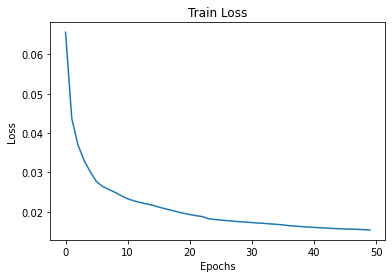

In [7]:
'''
Plot the train_loss trends
'''
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')